In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# setup some hyperparameters here：
lr = 5e-3
batch_size = 16
training_set_size = 2000
training_lower_range = -1 # define the training set range
traning_higher_range = 1

samples_per_edge = 1000 # define how may points we are going to pick on each Axis

num_epochs = 1500

layers = [2, 64, 64, 1]
activation = nn.Tanh()

In [ ]:
# define neural network
class PoissonPINN(nn.Module):
    def __init__(self, layers, activation):
        super(PoissonPINN, self).__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(activation)
        self.model = nn.Sequential(*self.layers)

    def forward(self, input_data):
        u = self.model(input_data)
        return u

In [ ]:
# generate the points for training, using latin hypercube sampling to make the generation average
def latin_hypercube_sampling(n: int, samples: int, low: float = -1.0, high: float = 1.0) -> torch.Tensor:
    """
    Latin Hypercube Sampling in a specified range [low, high]

    :param n: Dimension of the space
    :param samples: Number of samples to generate
    :param low: Lower bound of the range for each dimension
    :param high: Upper bound of the range for each dimension
    :return: A tensor of shape (samples, n) containing the Latin Hypercube samples
    """
    # Initial Latin Hypercube Sampling in [0, 1)
    lhs = torch.rand(samples, n)
    for d in range(n):
        # For each dimension, generate a permutation of indices and adjust positions
        lhs[:, d] = (torch.randperm(samples).float() + lhs[:, d]) / samples

    # Scale and shift the samples to the specified range [low, high]
    lhs = lhs * (high - low) + low

    return lhs
#print(latin_hypercube_sampling(2, training_set_size,-1,1))

# generate the boundary points, samples_per_edge is use to control the dense of the sample points in every edges
def generate_hypercube_boundary_points(dimensions, samples_per_edge, lower_bound=-1.0, upper_bound=1.0):
    boundary_points = []

    for dim in range(dimensions):
        # Points where one dimension is at the lower or upper bound
        for bound in [lower_bound, upper_bound]:
            grid = np.meshgrid(*[np.linspace(lower_bound, upper_bound, samples_per_edge) if d == dim else np.array([bound]) for d in range(dimensions)], indexing='ij')
            grid_points = np.stack(grid, axis=-1).reshape(-1, dimensions)
            boundary_points.append(grid_points)

    # Concatenate all points and convert to a PyTorch tensor
    boundary_points_tensor = torch.tensor(np.concatenate(boundary_points, axis=0), dtype=torch.float32)
    return boundary_points_tensor

#print(generate_hypercube_boundary_points(2, samples_per_edge,-1,1))

# generate evaluation datas
def create_evaluation_grid(lower_bound, upper_bound, steps=50):
    x = np.linspace(lower_bound, upper_bound, steps)
    y = np.linspace(lower_bound, upper_bound, steps)
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T
    return torch.tensor(grid, dtype=torch.float32), X, Y

# print(create_evaluation_grid(training_lower_range,traning_higher_range))


In [ ]:
# define f()
def f(x, y):
    #return 0
    return torch.sin(torch.pi *x) * torch.sin(torch.pi *y)


# define g()
def g(x, y):
    return torch.tensor(0.0)
    #return torch.sin(torch.pi * x)
    """
    # Apply different conditions based on the edge
    condition_left_right = torch.sin(np.pi * y)
    condition_top_bottom = torch.tensor(0.0)

    # Identify which edge each point belongs to
    on_left_right = (x == -1) | (x == 1)
    on_top_bottom = (y == -1) | (y == 1)

    # Apply the corresponding condition
    return torch.where(on_left_right, condition_left_right, condition_top_bottom)"""

In [ ]:
# loss function & PDE

def poission_loss_function(model, train_data, boundary_data, f,g):
    # do prediction
    u_pred = model(train_data)

    # calculate gradient
    u_grad = torch.autograd.grad(
        u_pred.sum(),
        train_data,
        create_graph = True
    )[0]

    #print(u_grad.shape)
    # Compute the residual (R) for each data point and take the mean squared error

    # Calculate second derivatives (Laplacian)
    u_xx = torch.autograd.grad(u_grad[:, 0].sum(), train_data, create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_grad[:, 1].sum(), train_data, create_graph=True)[0][:, 1]

    f_vals = f(train_data[:, 0], train_data[:, 1])  # Compute source term

    residuals =  u_xx + u_yy - f_vals
    loss_residual = (residuals ** 2).mean()  # Mean squared error of residuals

    # Compute the loss on boundary condition
    boundary_values = g(boundary_data[:, 0], boundary_data[:, 1])  # Compute boundary values
    loss_boundary = dirichlet_boundary_condition_loss(model, boundary_data, boundary_values)

    # Combine losses
    total_loss = loss_residual + loss_boundary
    return total_loss

def dirichlet_boundary_condition_loss(model, boundary_data, boundary_values):
    # Predictions by the neural network for the boundary data
    boundary_predictions = model(boundary_data)

    # Calculate the loss as the Mean Squared Error between predictions and true boundary values
    loss = torch.mean((boundary_predictions - boundary_values) ** 2)

    return loss


In [ ]:
# define how to train the model
    # Train the model
def train_model(model, epochs, optimizer, train_data, boundary_data, f, g):
    model.train() #change model in training model
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = poission_loss_function(model,train_data, boundary_data, f, g)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
            """
            # Predictions on the training data
            model.eval()  # Ensure the model is in evaluation mode
            with torch.no_grad():
              train_data_pred = model(train_data).numpy()

            #print(train_data_pred)

            # Plotting
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            # Scatter plot of training data and predictions
            # Assuming train_data[:, 0] is x and train_data[:, 1] is y
            ax.scatter(train_data[:, 0].detach().detach().numpy(), train_data[:, 1].detach().numpy(), train_data_pred, color='r', s=1)
            #ax.plot_surface(train_data[:, 0].detach().detach().numpy(), train_data[:, 1].detach().numpy(), train_data_pred, cmap='viridis', alpha=0.7)


            ax.set_xlabel('X axis')
            ax.set_ylabel('Y axis')
            ax.set_zlabel('Predicted Value')
            plt.show()"""

In [ ]:
if __name__ == '__main__':
    # Define your model, optimizer, training parameters
    model = PoissonPINN(layers, activation)# Your model here
    optimizer = optim.Adam(model.parameters(), lr=lr)# Your optimizer her

    # Generate training and boundary data
    train_data = latin_hypercube_sampling(2, training_set_size, training_lower_range, traning_higher_range)
    boundary_data = generate_hypercube_boundary_points(2, samples_per_edge, training_lower_range, traning_higher_range)

    # Create a grid for evaluation
    eval_grid, X, Y = create_evaluation_grid(training_lower_range, traning_higher_range)

    # train our model
    train_data.requires_grad_(True)
    train_model(model, num_epochs, optimizer, train_data, boundary_data, f,g)

    # save model
    from google.colab import drive
    drive.mount('/content/drive')
    #import os
    #os.chdir('/content/drive/My Drive')
    torch.save(model.state_dict(), 'poisson.pth')


Epoch 100, Loss: 0.003532793140038848
Epoch 200, Loss: 0.0015712399035692215
Epoch 300, Loss: 0.0009677153429947793
Epoch 400, Loss: 0.00034874866832979023
Epoch 500, Loss: 0.0001941586670000106
Epoch 600, Loss: 0.00013563409447669983
Epoch 700, Loss: 0.00010906516399700195
Epoch 800, Loss: 8.864002302289009e-05
Epoch 900, Loss: 9.467375639360398e-05
Epoch 1000, Loss: 6.709108856739476e-05
Epoch 1100, Loss: 6.2043902289588e-05
Epoch 1200, Loss: 0.0005556673859246075
Epoch 1300, Loss: 4.899410123471171e-05
Epoch 1400, Loss: 4.8808971769176424e-05
Epoch 1500, Loss: 4.126813291804865e-05


MessageError: ignored

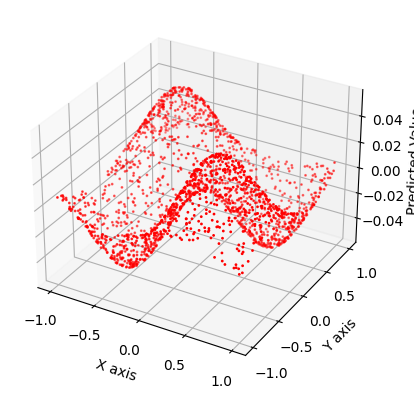

In [ ]:
    # Predictions on the training data
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        train_data_pred = model(train_data).numpy()

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of training data and predictions
    # Assuming train_data[:, 0] is x and train_data[:, 1] is y
    ax.scatter(train_data[:, 0].detach().detach().numpy(), train_data[:, 1].detach().numpy(), train_data_pred, color='r', s=1)
    #+ax.plot_wireframe(train_data[:, 0].detach().detach().numpy(), train_data[:, 1].detach().numpy(), train_data_pred, cmap='viridis')


    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Predicted Value')
    plt.show()

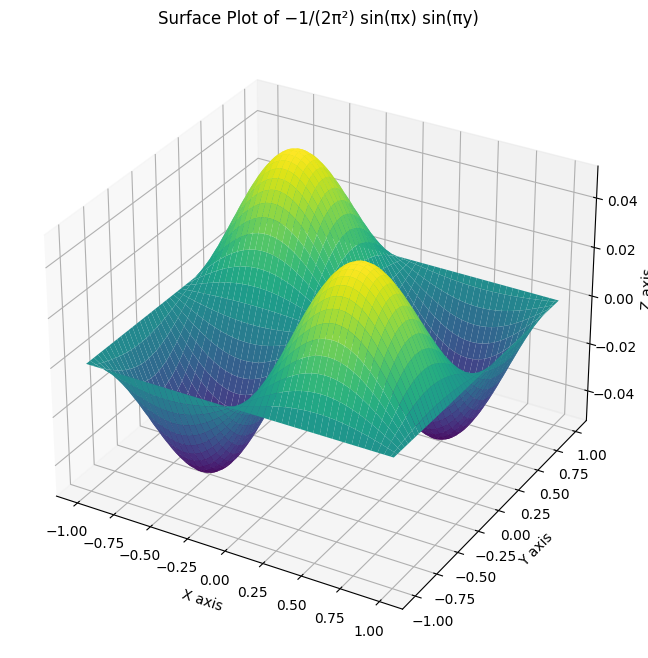

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function to be plotted
def func(x, y):
    #return np.sin(np.pi * x) * np.sin(np.pi * y)
    return -1/(2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Create a grid of x, y values
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Compute Z values
Z = func(X, Y)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Surface Plot of −1/(2π²) sin(πx) sin(πy)')

# Show the plot
plt.show()


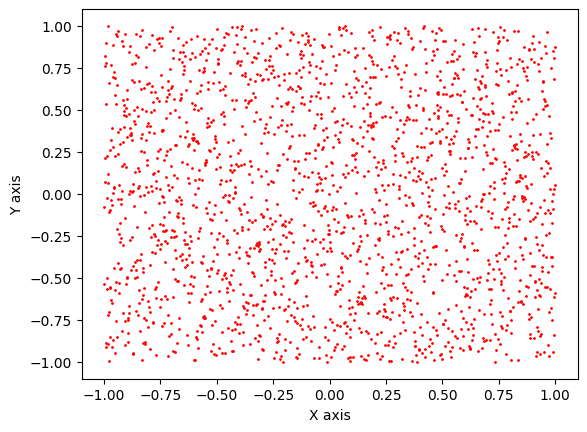

In [ ]:
  # Plotting
  fig, ax = plt.subplots()

  # Scatter plot of training data
  # Assuming train_data[:, 0] is x and train_data[:, 1] is y
  ax.scatter(train_data[:, 0].detach().numpy(), train_data[:, 1].detach().numpy(), color='r', s=1)

  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  plt.show()